In [1]:
import numpy as np
import h5py
import glob
import os
import sys
import re
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
%matplotlib inline
from os.path import expanduser
from itertools import zip_longest
home = expanduser("~")
host = os.getenv('HOSTNAME')
print(host)

None


In [2]:
if host is not None:
    if 'bebop' in host:
        input_dir = '/lcrc/project/galsampler/Catalog_5000/OR_5000/'
        size_dir = '/lcrc/project/galsampler/Validation_Data/Sizes'
else:
    #input_dir = '/lus/eagle/projects/LastJourney/kovacs/Catalog_5000/OR_5000/'
    #size_dir = '/lus/eagle/projects/LastJourney/kovacs/Validation_Data/Sizes'
    #laptop
    input_dir = '/Users/kovacs/Catalog_5000/OR_5000/roman_rubin_2023_v1.1.3'
    size_dir = '/Users/kovacs/Validation_Data/Sizes'
    notebook_dir = '/Users/kovacs/cosmology/diff_notebooks'
fname = 'roman_rubin_2023_z_*_cutout_{}.hdf5'
from diffaux.validation.get_catalog_data import get_fhlist
from diffaux.validation.get_catalog_data import get_colnames
#from lsstdesc_diffsky.write_mock_to_disk import get_astropy_table
from diffaux.size_modeling import zhang_yang17

In [572]:
validation_info = {'Re_vs_Mstar': {'samples': ['All', 'Star_forming', 'Quiescent'],
                                   'colors': ['black', 'blue', 'red'],
                                   'missing_values': '--',
                                   'filling_values': 0.0,
                                   'read': read_Re_vs_Mstar,
                                   'xlabel': '$\log_{10}(M^*/M_\odot)$',
                                   'ylabel': '$\log_{10}(R_{e}/\mathrm{kpc})$',
                                   'martorano_2024': {
                                       'filename': 'martorano_2024_table1_Mstar_log10Re_{}.txt',
                                       'skip_header': 10,
                                       'dz': .5,
                                       'z_lo': 0.5,
                                       'z_hi': 2.5,
                                       'M*_columns': [0, 1],
                                       'M*_colnames': ['M*_lo', 'M*_hi'],
                                       'data_colnames': ['M*_med', 'log10_Re_16%', 'log10_Re_50%', 'log10_Re_84%'],
                                       'x-values': 'M*_med',
                                       'y-values': 'log10_Re_50%',
                                       'y-error+': 'log10_Re_84%',
                                       'y-error-': 'log10_Re_16%',
                                       'suptitle': 'Martorano et al. 2024 - JWST & COSMOS',
                                       'wavelength': 1.5,
                                                    },
                                  },
                   'Re_vs_z': {
                               'missing_values': '--',
                               'filling_values': 0.0,
                               'read': read_Re_vs_z,
                               'x-values': 'M*med',
                               'y-values': ['B_{}','beta_{}'], 
                               'y-errors+': ['dB_{}+','dbeta_{}+'],
                               'y-errors-': ['dB_{}-','dbeta_{}-'],
                               'xlabels': ['$\log_{10}(M^*/M_\odot)$', '$\log_{10}(M^*/M_\odot)$'],
                               'ylabels': ['$B$ (kpc)', '$\\beta$'],
                               'titles': ['$B$: $R_e = B*(1 + z)^{-\\beta}$',
                                          '$\\beta$: $R_e = B*(1 + z)^{-\\beta}$'],
                               'xlabel': '$z$',
                               'ylabel': '$\log10(R_{e}/\mathrm{kpc})$',
                               'martorano_2024': {
                                   'samples': ['All', 'Star-forming', 'Quiescent'],
                                   'colors': ['black', 'blue', 'red'],
                                   'filename': 'martorano_2024_table2_Re_vs_z.txt',
                                   'skip_header': 4,
                                   'M*_colnames': ['M*_lo', 'M*_hi', 'M*med'],
                                   'M*_columns': [0, 1, 2],
                                   'data_colnames': ['alpha_{}', 'dalpha_{}+',  'dalpha_{}-',
                                                     'beta_{}',  'dbeta_{}+', 'dbeta_{}-',
                                                ],
                                   'flip_sign': True,
                                   'flip_value_columns': 3,
                                   'convert_from_log': True,
                                   'value_columns': [0],
                                   'error_columns': [1],
                                   'error_n_columns': [2],
                                   'markers': ['s', 's'],
                                   'wavelength': 1.5,
                                   'short_title': 'JWST, COSMOS',
                                   'suptitle': 'Martorano et. al. 2024 -- JWST, COSMOS',
                                                },
                               'george_2024_3000': {
                                   'samples': ['Star-forming', 'Quiescent'],
                                   'colors': ['mediumslateblue', 'crimson'],
                                   'filename': 'George_2024_Table3a_3000_Re_vs_z.txt',
                                   'skip_header': 5,
                                   'M*_colnames': ['M*med'],
                                   'M*_columns': [0],
                                   'data_colnames': ['B_{}', 'dB_{}+',
                                                     'beta_{}',  'dbeta_{}+',
                                                ],
                                   'flip_sign': True,
                                   'flip_value_columns': 2,
                                   'markers': ['X', 'X'],
                                   'wavelength': 0.3,
                                   'short_title': 'CLAUDS+HSC',
                                   'suptitle': 'George et. al. 2024 -- CLAUDS+HSC',
                                                },
                               'george_2024_5000': {
                                   'samples': ['Star-forming', 'Quiescent'],
                                   'colors': ['mediumslateblue', 'crimson'],
                                   'filename': 'George_2024_Table3b_5000_Re_vs_z.txt',
                                   'skip_header': 5,
                                   'M*_colnames': ['M*med'],
                                   'M*_columns': [0],
                                   'data_colnames': ['B_{}', 'dB_{}+',
                                                     'beta_{}',  'dbeta_{}+',
                                                ],
                                   'flip_sign': True,
                                   'flip_value_columns': 2,
                                   'markers': ['P', 'P'],
                                   'wavelength': 0.5,
                                   'short_title': 'CLAUDS+HSC',
                                   'suptitle': 'George et. al. 2024 -- CLAUDS+HSC',
                                                }, 
                               'kawinwanichakij_2021': {
                                   'samples': ['All', 'Quiescent', 'Star-forming'],
                                   'colors': ['black', 'firebrick', 'royalblue'],
                                   'filename': 'kawinwanichakij_Table6b_Re_vs_z.txt',
                                   'skip_header': 2,
                                   'M*_colnames': ['M*_lo', 'M*_hi', 'M*med'],
                                   'M*_columns': [0, 1, 2],
                                   'data_colnames': ['B_{}', 'dB_{}+',
                                                     'beta_{}',  'dbeta_{}+',
                                                ],
                                   'markers': ['D', 'D'],
                                   'wavelength': 0.5,
                                   'short_title': 'HSC',
                                   'suptitle': 'Kawinwanichakij et. al. 2021 -- HSC',
                                                },
                               'mowla_2019': {
                                         'samples': ['All', 'Star-forming', 'Quiescent'],
                                         'colors': ['black', 'mediumblue', 'crimson'],
                                         'filename': 'mowla_2019_table1b_3b_Re_vs_z.txt',
                                         'skip_header': 3,
                                         'M*_colnames': ['M*med'],
                                         'M*_columns': [0],
                                         'data_colnames': ['B_{}', 'dB_{}+', 'beta_{}',  'dbeta_{}+'],
                                         'markers': ['o', 'o'],
                                         'wavelength': 0.55,
                                         'short_title': 'COSMOS-DASH',
                                         'suptitle': 'Mowla et al. 2019 -- COSMOS-DASH',
                                             },
                               'vanderWel_2014': {
                                         'samples': ['Star-forming', 'Quiescent'],
                                         'colors': ['dodgerblue', 'orangered'],
                                         'filename': 'vanderWel_2014_table2_Re_vs_z.txt',
                                         'skip_header': 5,
                                         'M*_colnames': ['M*med'],
                                         'M*_columns': [0],
                                         'data_colnames': ['alpha_{}', 'dalpha_{}+', 'beta_{}',  'dbeta_{}+'],
                                         'markers': ['^', '^'],
                                         'flip_sign': True,
                                         'flip_value_columns': 2,
                                         'convert_from_log': True,
                                         'value_columns': [0],
                                         'error_columns': [1],
                                         'wavelength': 0.5,
                                         'short_title': '3D-HST+CANDELS',
                                         'suptitle': 'van der Wel et al. 2014 -- 3D-HST+CANDELS',
                                             },
                              },
            }
def read_size_data(data, authors, validation_info=validation_info, info_key='Re_vs_Mstar', sample='', size_dir=size_dir):
    # setup data dict
    if info_key not in data.keys(): data[info_key] = {}
    v_info = validation_info[info_key]
    for author in authors:
        if author in v_info.keys():
            if author not in data[info_key].keys(): data[info_key][author] = {}
            fn= os.path.join(size_dir, author, v_info[author]['filename'].format(sample))
            print('Reading data from {}'.format(fn))
            tmp = np.genfromtxt(fn, skip_header=v_info[author]['skip_header'],
                                missing_values=v_info['missing_values'],
                                filling_values=v_info['filling_values'],
                               )
            if info_key == 'Re_vs_Mstar':
                data[info_key][author] = v_info['read'](tmp, data[info_key][author], sample, v_info[author])
            elif info_key == 'Re_vs_z':
                data[info_key][author] = v_info['read'](tmp, data[info_key][author], author, v_info)

    return data

def read_Re_vs_Mstar(tmp, data, sample, validation_info):
    #collect M* values if not already in dict
    if not all([cname in data.keys() for cname in validation_info['M*_colnames']]):
        for col, colname in zip(validation_info['M*_columns'], validation_info['M*_colnames']):
            data[colname] = tmp[:, col]

    
    #collect M_med, log10(R_e) values for each z bin
    for n, zlo in enumerate(np.arange(validation_info['z_lo'], validation_info['z_hi'],
                                      validation_info['dz'])):
        zhi = zlo + validation_info['dz']
        #print(n, zlo, zhi)
        zlabel = '${:.1f} \leq z < {:.1f}$'.format(zlo, zhi)
        if zlabel not in data.keys(): data[zlabel] = {}
        if sample not in data[zlabel].keys(): data[zlabel][sample] = {}
        for i, colname  in enumerate(validation_info['data_colnames']):
            col = len(validation_info['M*_columns']) + i + n*len(validation_info['data_colnames'])
            data[zlabel][sample][colname] = tmp[:, col]
    
    return data

def read_Re_vs_z(tmp, data, author, validation_info):

    # collect M* columns 
    v = validation_info[author]
    for col, colname in zip(v['M*_columns'], v['M*_colnames']):
        data[colname] = tmp[:, col]

    for n, sample in enumerate(validation_info[author]['samples']):
        for i, colname in enumerate(v['data_colnames']):
            col = len(v['M*_columns']) + i + n*len(v['data_colnames'])
            colname = colname.format(sample)
            data[colname] = tmp[:, col]
            #assume only one sign flip required
            if 'flip_sign' in v.keys() and colname == v['data_colnames'][v['flip_value_columns']].format(sample):
                data[colname] = -data[colname]
                print('Flipping sign of {}'.format(colname))

    # Check for logarithmic values in data and single-sided error values
    # and complete columns so that all data sets match
    for sample in validation_info[author]['samples']:
        for n, (yval, yerr_p, yerr_n) in enumerate(zip(validation_info['y-values'],
                                                       validation_info['y-errors+'],    
                                                       validation_info['y-errors-'])):
            yval = yval.format(sample)
            yerr_p = yerr_p.format(sample)
            yerr_n = yerr_n.format(sample)
            if 'convert_to_log' in v.keys() or 'convert_from_log' in v.keys():
                if yval not in data.keys():
                    # convert value columns and error columns to or from log
                    val_idx = v['value_columns'][n] 
                    err_idx = v['error_columns'][n]
                    old_val = v['data_colnames'][val_idx].format(sample)
                    data[yval] = np.zeros(len(data[old_val]))
                    old_err = v['data_colnames'][err_idx].format(sample)
                    data[yerr_p] = np.zeros(len(data[old_val]))
                    if 'error_n_columns' in v.keys():
                        err_n_idx = v['error_n_columns'][n]
                        data[yerr_n] = np.zeros(len(data[old_val]))
                        old_err_n = v['data_colnames'][err_n_idx].format(sample)
                    mask = data[old_val] != 0
                    if 'convert_to_log' in v.keys() and v['convert_to_log']:
                        data[yval][mask] = np.log10(data[old_val][mask])
                        print('..Converting {} to log'.format(old_val))
                        data[yerr_p][mask] = np.log10(data[old_val][mask]
                                                 + data[old_err][mask]) - data[yval][mask]
                        print('..Converting {} to log'.format(old_err))
                    elif 'convert_from_log' in v.keys() and v['convert_from_log']:
                        #conversion of log(beta) to beta; (beta should be +ve)
                        data[yval][mask] = np.power(10, data[old_val][mask])
                        #print(data[old_val][mask], '->', data[yval][mask])
                        print('..Converting {} from log to {}'.format(old_val, yval))
                        data[yerr_p][mask] = np.abs(np.power(10, (data[old_val][mask]
                                                    + data[old_err][mask])) - data[yval][mask])
                        #Check for asymmetric errors
                        if 'error_n_columns' in v.keys():
                            data[yerr_n][mask] = np.abs(-np.power(10, (data[old_val][mask]
                                                       - data[old_err][mask])) + data[yval][mask])
                        print('..Converting {} from log to {}'.format(old_err, yerr_p))
            if yerr_n not in data.keys():
                data[yerr_n] = data[yerr_p]
                print('..Assigning symmetric errors for {}'.format(yerr_n))
                
        
    return data

In [731]:
authors = ['martorano_2024', 'george_2024_3000', 'george_2024_5000', 
           'kawinwanichakij_2021', 'mowla_2019', 'vanderWel_2014']
#authors = ['vanderWel_2014']
data = {}
#for sample in validation_info['Re_vs_Mstar']['samples']:
#    data= read_size_data(data, authors, info_key='Re_vs_Mstar', sample=sample)
data= read_size_data(data, authors, info_key='Re_vs_z')
#print(data['Re_vs_z'])

Reading data from /Users/kovacs/Validation_Data/Sizes/martorano_2024/martorano_2024_table2_Re_vs_z.txt
Flipping sign of beta_All
Flipping sign of beta_Star-forming
Flipping sign of beta_Quiescent
..Converting alpha_All from log to B_All
..Converting dalpha_All+ from log to dB_All+
..Converting alpha_Star-forming from log to B_Star-forming
..Converting dalpha_Star-forming+ from log to dB_Star-forming+
..Converting alpha_Quiescent from log to B_Quiescent
..Converting dalpha_Quiescent+ from log to dB_Quiescent+
Reading data from /Users/kovacs/Validation_Data/Sizes/george_2024_3000/George_2024_Table3a_3000_Re_vs_z.txt
Flipping sign of beta_Star-forming
Flipping sign of beta_Quiescent
..Assigning symmetric errors for dB_Star-forming-
..Assigning symmetric errors for dbeta_Star-forming-
..Assigning symmetric errors for dB_Quiescent-
..Assigning symmetric errors for dbeta_Quiescent-
Reading data from /Users/kovacs/Validation_Data/Sizes/george_2024_5000/George_2024_Table3b_5000_Re_vs_z.txt
Fli

In [574]:
from diffaux.validation.make_plots import get_nrow_ncol, save_fig, fix_plotid

def plot_Re_vs_Mstar(data, author, validation_info, plotdir=os.path.join(notebook_dir, 'SizePlots'),
              pltname='log10Re_vs_Mstar_{}.pdf'):

    zkeys = [k for k in data.keys() if 'z' in k]
    nrow, ncol = get_nrow_ncol(len(zkeys))
    fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    for ax, zlabel in zip(ax_all.flat, zkeys):
        for (sample, v), color in zip(data[zlabel].items(), validation_info['colors']):
            xcol = validation_info[author]['x-values']
            ycol = validation_info[author]['y-values']
            mask = v[xcol] > 0.
            if np.count_nonzero(mask) > 0:
                ax.plot(v[xcol][mask], v[ycol][mask], color=color, label=sample)
                ax.fill_between(v[xcol][mask], v[validation_info[author]['y-error-']][mask], 
                                v[validation_info[author]['y-error+']][mask],
                                facecolor=color, alpha=0.2)
        ax.set_xlabel(validation_info['xlabel'])
        ax.set_ylabel(validation_info['ylabel'])
        ax.legend(loc='best')
        ax.set_title(zlabel)
        
    fig.tight_layout()
    fig.suptitle(validation_info[author]['suptitle'], y=1.01)

    pltname = pltname.format(author)
    save_fig(fig, plotdir, pltname)

    return

def plot_Re_vs_z(data, author, validation_info, plotdir=os.path.join(notebook_dir, 'SizePlots'),
                 pltname='Re_vs_z_{}.png', summary_fig=None, summary_ax=None, save_summary=False):

    # fit coefficient plot: log10(Re) = α1 + β1 log10(1 + z)
    nrow, ncol = get_nrow_ncol(len(validation_info['y-values']))
    fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    if summary_fig is None:
        summary_fig, summary_ax = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    for ax, sumax, yvalue, yerr_p, yerr_m, xlabel, ylabel, marker, title in zip(ax_all.flat,
                                                                        summary_ax.flat,
                                                                        validation_info['y-values'],
                                                                        validation_info['y-errors+'],
                                                                        validation_info['y-errors-'],
                                                                        validation_info['xlabels'],
                                                                        validation_info['ylabels'],
                                                                        validation_info[author]['markers'],
                                                                        validation_info['titles'],
                                                         ):
        for sample, color in zip(validation_info[author]['samples'],validation_info[author]['colors']):
            xcol = validation_info['x-values']
            ycol = yvalue.format(sample)
            lower_error = np.abs(data[yerr_p.format(sample)])
            upper_error = np.abs(data[yerr_m.format(sample)])
            #mask for missing values
            mask = np.abs(data[ycol]) > 0.
            #print(asymmetric_error)
            if np.count_nonzero(mask) > 0:
                asymmetric_error = [lower_error[mask], upper_error[mask]]
                ax.errorbar(data[xcol][mask], data[ycol][mask], yerr=asymmetric_error, label=sample, color=color,
                            marker=marker, linestyle='')
                sum_label = '{} ({}) ${}\mu m$'.format(sample, validation_info[author]['short_title'],
                                                validation_info[author]['wavelength'])
                if 'All' not in sample:
                    sumax.errorbar(data[xcol][mask], data[ycol][mask], yerr=asymmetric_error, label=sum_label, color=color,
                                   marker=marker, linestyle='')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend(loc='best')

        if save_summary:
            sumax.set_xlabel(xlabel)
            sumax.set_ylabel(ylabel)
            sumax.set_title('{}'.format(title))
            sumax.legend(loc='best', ncols=2, fontsize='x-small')
                                           
    if 'M*_lo' in validation_info[author]['M*_colnames'] and 'M*_hi' in validation_info[author]['M*_colnames']:
        idx_lo = validation_info[author]['M*_colnames'].index('M*_lo')
        idx_hi = validation_info[author]['M*_colnames'].index('M*_hi')
        for Mlo, Mhi in zip(data[validation_info[author]['M*_colnames'][idx_lo]],
                        data[validation_info[author]['M*_colnames'][idx_hi]]):
            Mlabel = '${:.1f} \leq \log10(M^*/M_\odot) < {:.1f}$'.format(Mlo, Mhi)


    #fig.tight_layout()
    fig.suptitle('{} ({})'.format(validation_info[author]['suptitle'],
                                  validation_info[author]['wavelength']), y=1.01)

    save_fig(fig, plotdir, pltname.format(author))
    if save_summary:
        save_fig(summary_fig, plotdir, pltname.format('summary'))
        
    
    return summary_fig, summary_ax

Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_martorano_2024.png
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_george_2024_3000.png
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_george_2024_5000.png
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_kawinwanichakij_2021.png
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_mowla_2019.png
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_vanderWel_2014.png
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_summary.png


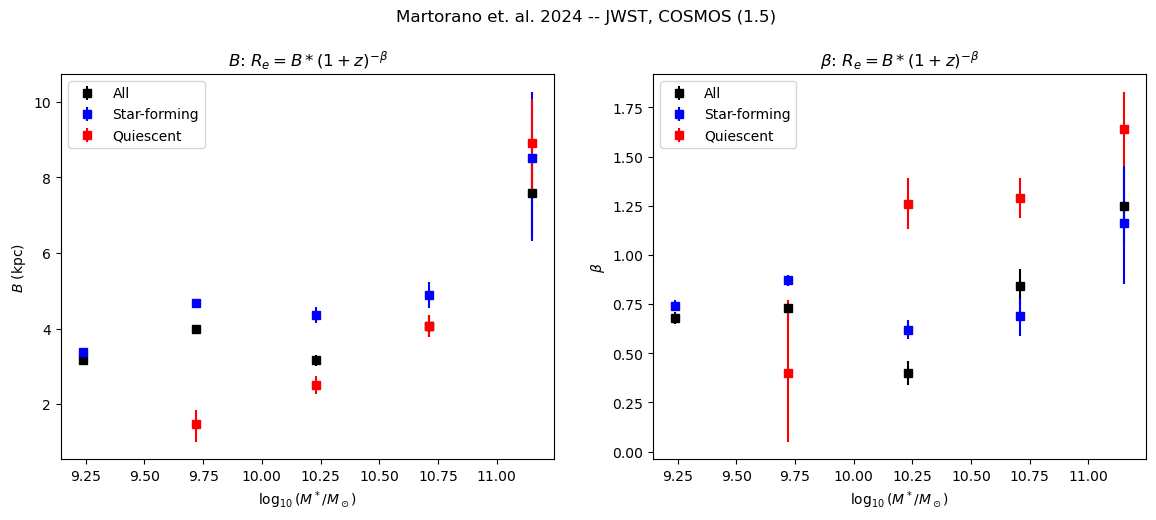

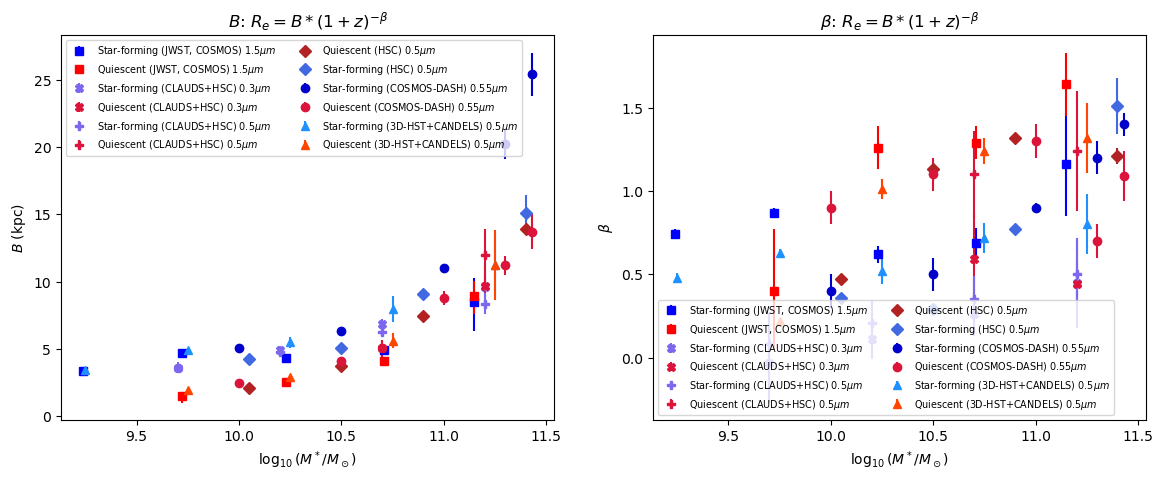

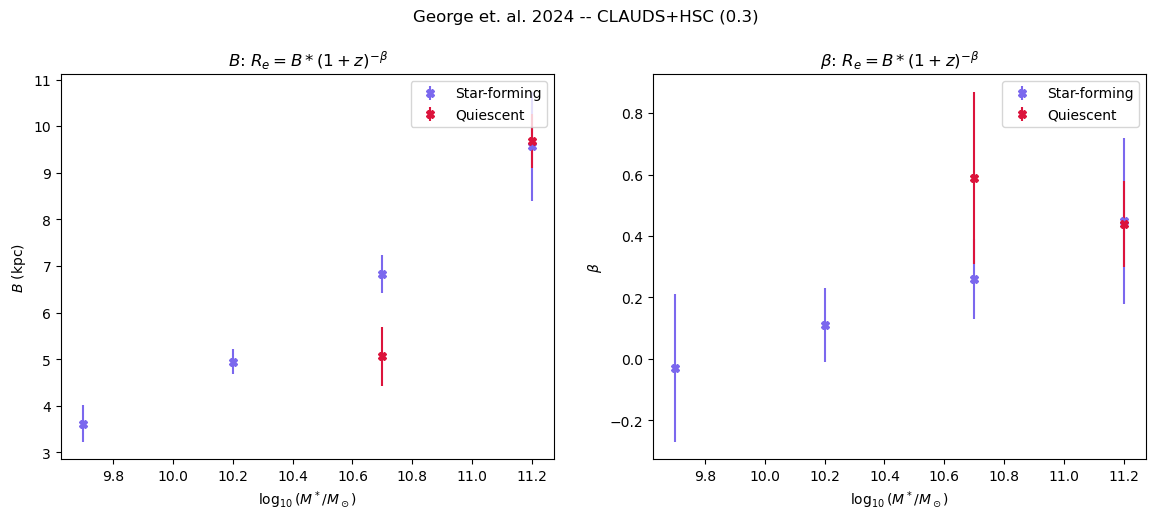

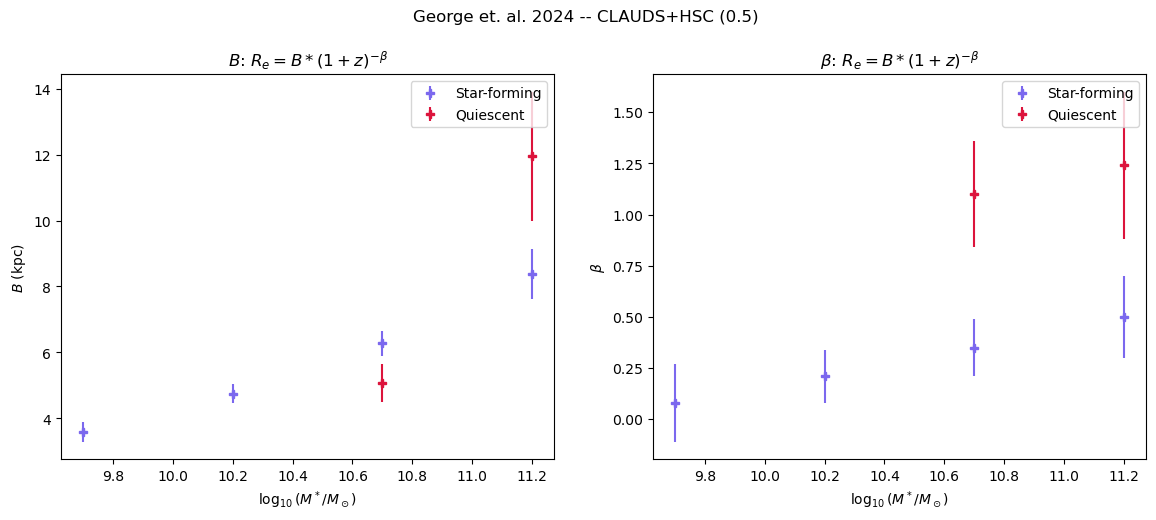

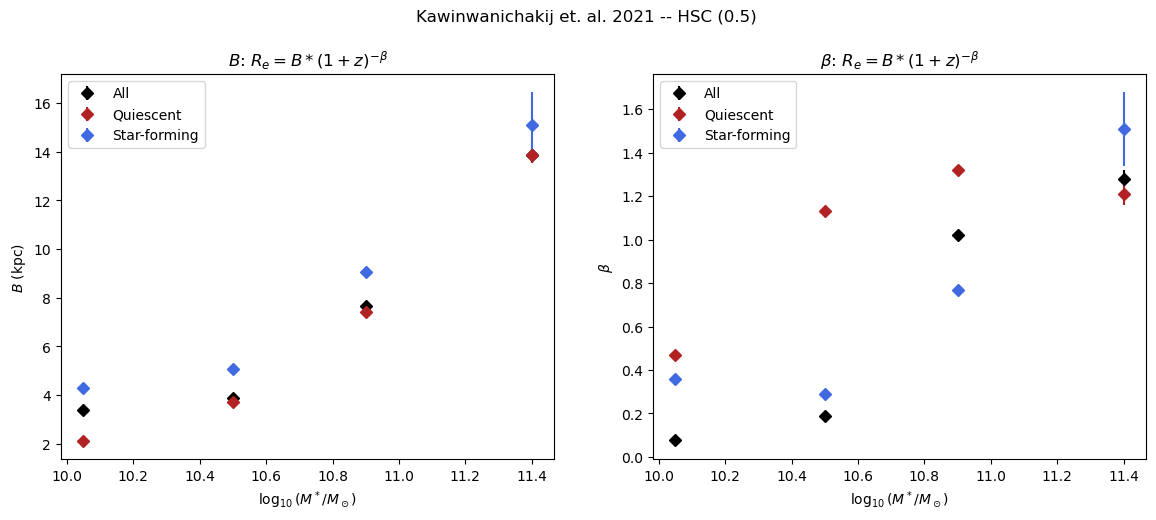

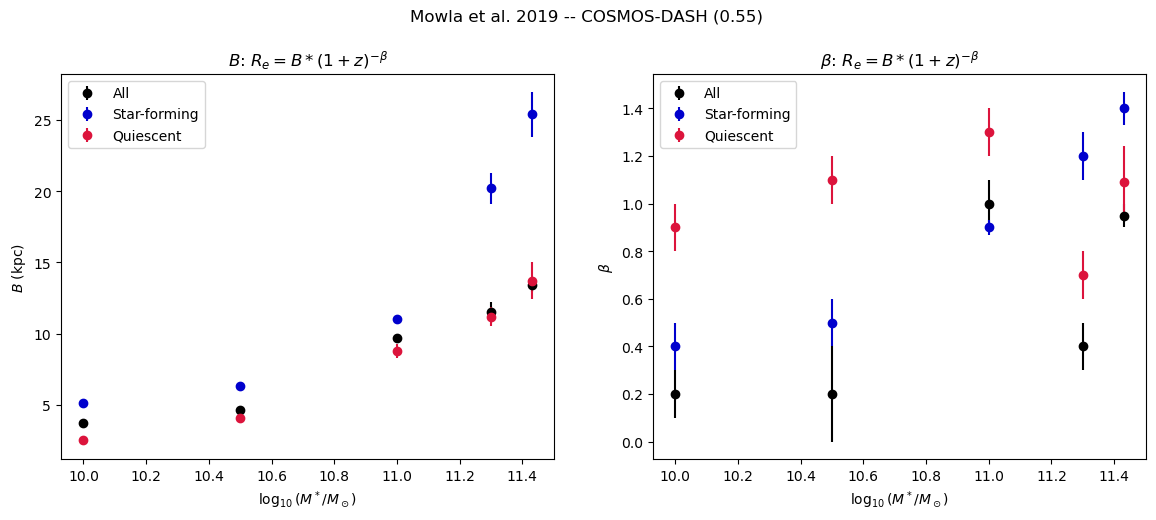

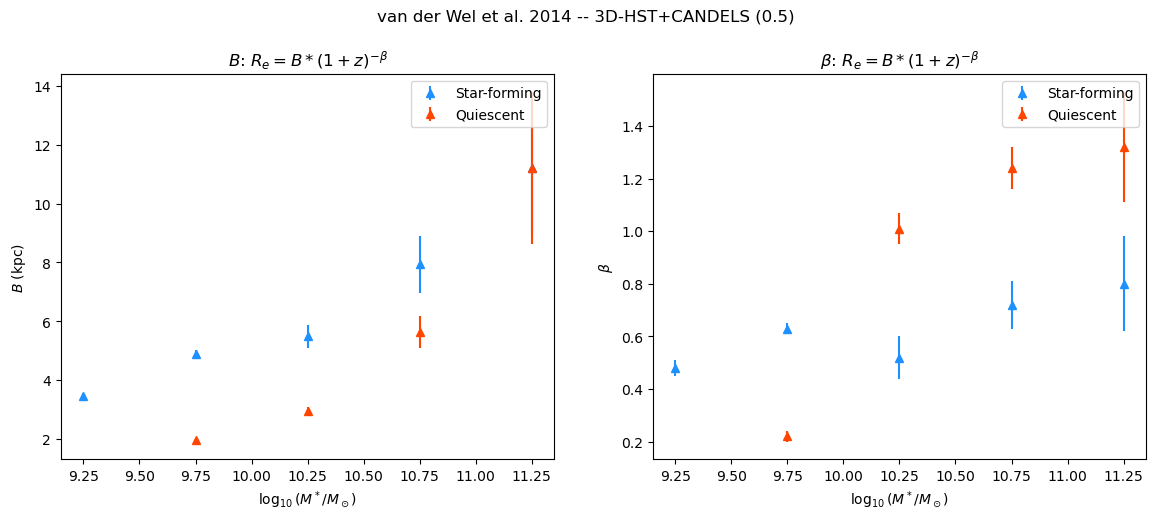

In [575]:
#log10(Re) = α + β*log10(1 + z)
sum_fig = None
sum_ax = None
for author in authors:
    if 'Re_vs_Mstar' in data.keys() and author in data['Re_vs_Mstar'].keys():
        plot_Re_vs_Mstar(data['Re_vs_Mstar'][author], author, validation_info['Re_vs_Mstar'])
    if 'Re_vs_z' in data.keys() and author in data['Re_vs_z'].keys():
        save_summary = (author == authors[-1])
        sum_fig, sum_ax = plot_Re_vs_z(data['Re_vs_z'][author], author, validation_info['Re_vs_z'],
                                       summary_fig=sum_fig, summary_ax=sum_ax, save_summary=save_summary)

In [762]:
# fit data points for B and beta with a power law in M*
from scipy.optimize import curve_fit
    
# collect data points
def get_data_vectors(data, val_info, sample='Star-forming', lambda_min=0.5, lambda_max=1.0,
                     X='x-values', Y='y-values', dYp='y-errors+', dYn='y-errors-'):
    #initialize
    xvec = np.asarray([])
    yvec = []
    dyvec = []
    for yname in val_info[Y]:
        yvec.append(np.asarray([]))
        dyvec.append(np.asarray([]))
    for k, v in data.items():
        wave = val_info[k]['wavelength']
        if wave >= lambda_min and wave <= lambda_max:
            print('Processing {} {}'.format(k, wave))
            add_xvec = True
            #print(val_info[X], xvec)
            for n, (y, dy, yn, dynp, dynn) in enumerate(zip(yvec, dyvec,
                                                          val_info[Y], val_info[dYp], val_info[dYn])):
                #print(yname,  v[yname.format(sample)])
                mask = np.abs(v[yn.format(sample)]) > 0.
                if add_xvec:
                    xvec = np.concatenate((xvec, v[val_info[X]][mask]))
                    add_xvec = False
                y = np.concatenate((y, v[yn.format(sample)][mask]))
                yerr = np.fmax(v[dynp.format(sample)], v[dynn.format(sample)])
                dy = np.concatenate((dy, yerr[mask]))
                yvec[n] = y
                dyvec[n] = dy
        else:
            print('Skipping {} {}'.format(k, wave))
            
        

    assert(all([len(xvec) == len(y) for y in yvec])), 'Mismatch in assembled data vectors'
    return xvec, yvec, dyvec

In [774]:
data_vectors = {}
fit_type = 'Re_vs_z'
data_vectors['Re_vs_z'] = {}
samples = ['Star-forming', 'Quiescent']
for sample in samples:
    data_vectors[fit_type][sample] = {}
    x, y, dy = get_data_vectors(data[fit_type], validation_info[fit_type], sample=sample)
    data_vectors[fit_type][sample]['x'] = x
    data_vectors[fit_type][sample]['y'] = y
    data_vectors[fit_type][sample]['dy'] = dy

Skipping martorano_2024 1.5
Skipping george_2024_3000 0.3
Processing george_2024_5000 0.5
Processing kawinwanichakij_2021 0.5
Processing mowla_2019 0.55
Processing vanderWel_2014 0.5
Skipping martorano_2024 1.5
Skipping george_2024_3000 0.3
Processing george_2024_5000 0.5
Processing kawinwanichakij_2021 0.5
Processing mowla_2019 0.55
Processing vanderWel_2014 0.5


In [775]:
print(data_vectors)

{'Re_vs_z': {'Star-forming': {'x': array([ 9.7 , 10.2 , 10.7 , 11.2 , 10.05, 10.5 , 10.9 , 11.4 , 10.  ,
       10.5 , 11.  , 11.3 , 11.43,  9.25,  9.75, 10.25, 10.75, 11.25]), 'y': [array([ 3.59      ,  4.75      ,  6.28      ,  8.37      ,  4.28      ,
        5.05      ,  9.07      , 15.09      ,  5.1       ,  6.3       ,
       11.        , 20.2       , 25.4       ,  3.4673685 ,  4.89778819,
        5.49540874,  7.94328235, 11.22018454]), array([0.08, 0.21, 0.35, 0.5 , 0.36, 0.29, 0.77, 1.51, 0.4 , 0.5 , 0.9 ,
       1.2 , 1.4 , 0.48, 0.63, 0.52, 0.72, 0.8 ])], 'dy': [array([0.3       , 0.28      , 0.38      , 0.76      , 0.02      ,
       0.02      , 0.12      , 1.38      , 0.2       , 0.2       ,
       0.3       , 1.1       , 1.6       , 0.08076539, 0.11408414,
       0.39302781, 0.96922703, 2.26944428]), array([0.19, 0.13, 0.14, 0.2 , 0.01, 0.01, 0.02, 0.17, 0.1 , 0.1 , 0.03,
       0.1 , 0.07, 0.03, 0.02, 0.08, 0.09, 0.18])]}, 'Quiescent': {'x': array([10.7 , 11.2 , 10.05, 10

In [778]:
def pwrfit(x, X_0, x0, a, b):
    return X_0 + a*np.power(x-x0, b)

def expfit(x, X_0, x0, a, b):
    return X_0 + a*np.exp(b*(x-x0))

def fit_parameters(data_vectors, samples, val_info, p0_values,
                   func=expfit, fit_type='Re_vs_z', xvalue='x'):
    parameters = val_info['y-values']
    fits = {}
    for sample in samples:
        M = data_vectors[sample][xvalue]
        for par, p0, y, dy in zip(parameters, p0_values,
                                  data_vectors[sample]['y'],
                                  data_vectors[sample]['dy']):
            #print(par, M, y, dy, p0)
            fit_key = par.format(sample)
            fits[fit_key] = {}
            popt, pcov = curve_fit(func, M, y, sigma=dy, p0=p0, absolute_sigma=True)
            perr = np.sqrt(np.diag(pcov))
            fits[fit_key]['popt'] = popt
            fits[fit_key]['perr'] = perr
            fits[fit_key]['pcov'] = pcov

    print(fits)
    return fits

def plot_fits(fits, data_vectors, samples, val_info,
              func=expfit, xvalue='x',
              plotdir=os.path.join(notebook_dir, 'SizePlots'), pltname='Fit_Re_vs_z.png',
             ):
    parameters = val_info['y-values']
    nrow = len(samples)
    ncol = len(parameters)
    fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    for sample, ax_row, color in zip(samples, ax_all, ('blue', 'red')):
        M = data_vectors[sample][xvalue]
        for par, ax, y, dy, xlabel in zip(parameters, ax_row, data_vectors[sample]['y'],
                                          data_vectors[sample]['dy'],
                                          val_info['xlabels']):
            fit_key = par.format(sample)
            ax.errorbar(M, y, yerr=dy, label=fit_key, color=color, marker='o', linestyle='')
            popt =  fits[fit_key]['popt']
            Msort = np.sort(M)
            ax.plot(Msort, func(Msort, *popt))
            ax.set_xlabel(xlabel)
            ax.set_ylabel(fit_key)
            ax.set_title(sample)
            ax.legend(loc='best')

            
    return

In [780]:
#plt.plot(xdata, ydata, 'b-', label='data')
p0_values = [(0.0, 10.5, 4.0, 1.0), (0.0, 10.5, 0.5, 1.0)]
fit_type='Re_vs_z'

fits[fit_type] = fit_parameters(data_vectors[fit_type], samples, validation_info[fit_type], p0_values, func=pwrfit)
plot_fits(fits[fit_type], data_vectors[fit_type], samples, validation_info[fit_type], func=pwrfit)
#plot_fits(fits, data_vectors, samples, fit_pars, p0_values)
#fits = fit_parameters(fits, data_vectors, samples, validation_info, p0_values)

/var/folders/hf/_gh49mcn1m534wqwdyjxznnm0000gn/T/ipykernel_18180/2933646104.py:2: RuntimeWarning: invalid value encountered in power
  return X_0 + a*np.power(x-x0, b)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.